### Naive Bayes Spam Filter

### ```1.0.0``` Import Packages

In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from sklearn.model_selection import train_test_split
from collections import defaultdict

In [2]:
f_train_feat = "data/train-features.txt"
f_train_label = "data/train-labels.txt"
f_test_feat = "data/test-features.txt"
f_test_label = "data/test-labels.txt"
cols = ['MSG_NO','WORD_NO','CURR_FREQ']
output = ['SPAM']

### ```2.1.0``` Preprecess raw data

In [3]:
#import dataset
df_train_feat = pd.read_csv(f_train_feat,delimiter=' ',names=cols)
df_train_label = pd.read_csv(f_train_label,delimiter=' ',names=output)

df_test_feat = pd.read_csv(f_test_feat,delimiter=' ',names=cols)
df_test_label = pd.read_csv(f_test_label,delimiter=' ',names=output)

In [4]:
df_train_feat['SPAM'] = -1
df_test_feat['SPAM'] = -1
df_test_feat['PREDICTED SPAM'] = -1

In [5]:
for i in range (0,df_train_label.shape[0]):
    df_train_feat.loc[df_train_feat.MSG_NO == i+1,'SPAM'] = df_train_label.iloc[i]['SPAM']
    
for i in range (0,df_test_label.shape[0]):
    df_test_feat.loc[df_test_feat.MSG_NO == i+1,'SPAM'] = df_test_label.iloc[i]['SPAM']

### ```3.1.0``` Naive Bayes approach

* probability for a set of samples : $P(\vec{samples}|class) = \prod_{i=1}^{n}P(sample_{i}|class)$
* conditional probability for a class given samples : $P(class_{i} | \vec{samples}) = \dfrac{P(class_{i})P(\vec{samples} | class_i)}{\displaystyle\sum_{i=1}^{n}{P(class_i)P(\vec{samples}|class_i)}}$



In [6]:
#helper functions 
def p_xi_spam(df,xi):
    total = df[df['SPAM'] == 1]['MSG_NO'].nunique()
    n_spam_xi = 0
    for i in df[df['SPAM'] == 1]['MSG_NO'].unique():
        if i in df[df['WORD_NO'] == xi]['MSG_NO'].values:
            n_spam_xi+=1
    return n_spam_xi/total

def p_xi_ham(df,xi):
    total = df[df['SPAM'] == 0]['MSG_NO'].nunique()
    n_ham_xi = 0
    for i in df[df['SPAM'] == 0]['MSG_NO'].unique():
        if i in df[df['WORD_NO'] == xi]['MSG_NO'].values:
            n_ham_xi+=1
    return n_ham_xi/total

def p_spam(df):
    total = df['MSG_NO'].nunique()
    n_spam = df[df['SPAM'] == 1]['MSG_NO'].nunique()
    return n_spam/total

def p_ham(df):
    total = df['MSG_NO'].nunique()
    n_ham = df[df['SPAM'] == 0]['MSG_NO'].nunique()
    return n_ham/total

def populate_dict(df):
    sdict = defaultdict(int)
    hdict = defaultdict(int)
    for index,row in df.iterrows():
        if row['SPAM'] == 1:
            sdict[row['WORD_NO']] += row['CURR_FREQ']
        else:
            hdict[row['WORD_NO']] += row['CURR_FREQ']
    return sdict,hdict


def predict_naivebayes(df_train_feat,df_test_feat,s_alpha=1.0,s_beta=2.0):
    msgno = 0
    p_spam = 0
    p_ham = 0
    
    sdict = defaultdict(int)
    hdict = defaultdict(int)
    sdict,hdict = populate_dict(df_train_feat)

    spam_length = df_train_label[df_train_label['SPAM'] == 1].shape[0]
    ham_length = df_train_label[df_train_label['SPAM'] == 0].shape[0]
    
    test_spam_length = df_test_label[df_test_label['SPAM'] == 1].shape[0]
    test_ham_length = df_test_label[df_test_label['SPAM'] == 0].shape[0]

    test_p_spam = (test_spam_length /  test_spam_length + test_ham_length )
    test_p_ham = (test_ham_length /  test_spam_length + test_ham_length )
    
    # for each word of each message
    for index,row in df_test_feat.iterrows():
        if (msgno != row["MSG_NO"]):
            p_spam = 0
            p_ham = 0
       
        # laplace smoothing
        p_x_spam = ( sdict[row["WORD_NO"]] + s_alpha ) / (spam_length + s_beta )
        p_x_ham = ( hdict[row["WORD_NO"]] + s_alpha ) / (ham_length + s_beta )
    
        p_spam += ( np.log( p_x_spam ) * row["CURR_FREQ"] )
        p_ham += ( np.log( p_x_ham ) * row["CURR_FREQ"] )
    
        msgno = row["MSG_NO"]
        mask = (df_test_feat['MSG_NO'] == msgno)
        
        if p_spam + np.log(test_p_spam) > p_ham + np.log(test_p_ham):
            df_test_feat['PREDICTED SPAM'][mask] = 1
        else:
            df_test_feat['PREDICTED SPAM'][mask] = 0
            
    return df_test_feat

### ```4.1.0``` Classifying messages

In [7]:
# generate test msgs
df_test_feat = predict_naivebayes(df_train_feat,df_test_feat)
df_test_feat

,MSG_NO,WORD_NO,CURR_FREQ,SPAM,PREDICTED SPAM
0,1,8,1,0,0
1,1,9,1,0,0
2,1,17,1,0,0
3,1,19,1,0,0
4,1,29,1,0,0
...,...,...,...,...,...
27974,260,1512,1,1,1
27975,260,1624,1,1,1
27976,260,1967,1,1,1
27977,260,1974,2,1,1


### ```5.1.0``` Visualizing Results

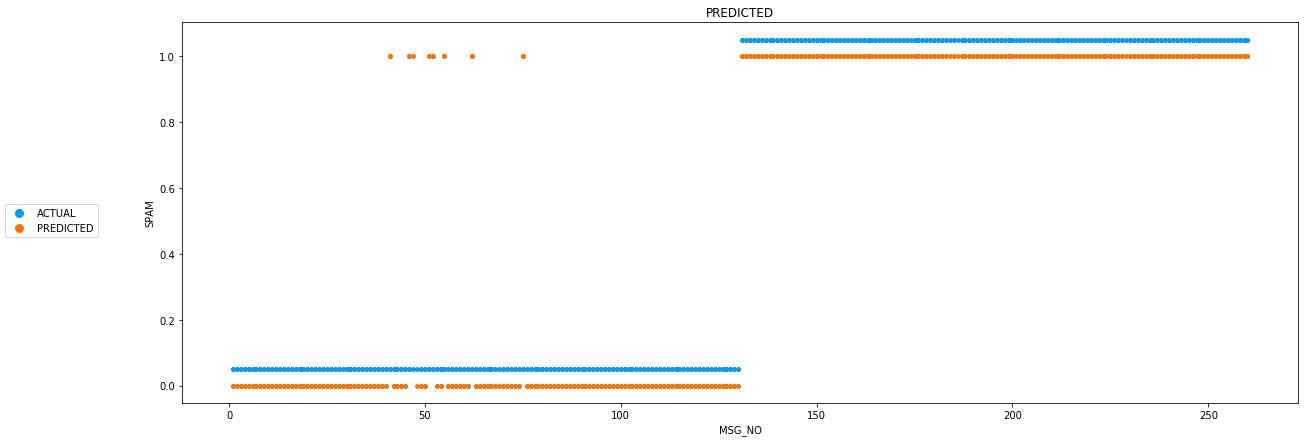

In [8]:
fig, arr = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=True)
fig.set_figwidth(20)
fig.set_figheight(7)
legend_elements = [Line2D([0], [0], marker='o', color='w', label='ACTUAL',
                          markerfacecolor='xkcd:azure', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='PREDICTED',
                          markerfacecolor='xkcd:orange', markersize=10)
                  ]

fig.legend(handles=legend_elements, loc='center left')
arr.plot(df_test_feat['MSG_NO'],df_test_feat['PREDICTED SPAM'],'.',c='xkcd:orange')
arr.plot(df_test_feat['MSG_NO'],df_test_feat['SPAM']+0.05,'.',c='xkcd:azure')
arr.set_title('PREDICTED')
arr.set_xlabel('MSG_NO')
arr.set_ylabel('SPAM')
fig.show()

### ```6.1.0``` Accuracy Score

In [9]:
match = df_test_feat[(df_test_feat['SPAM'] == df_test_feat['PREDICTED SPAM'])]['MSG_NO'].nunique()
total = df_test_feat['MSG_NO'].nunique()
accuracy = match/total*100
df_accuracy = pd.DataFrame([[match,total,accuracy]],columns=['MATCHES','TOTAL MESSAGES','ACCURACY SCORE'])
df_accuracy

,MATCHES,TOTAL MESSAGES,ACCURACY SCORE
0,252,260,96.923077
